In [9]:
from utility import format_missing_values, features_selection

from tqdm import tqdm
import pandas as pd

import numpy as np

tqdm.pandas()

from sklearn import  metrics
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow_hub as hub

import warnings
warnings.filterwarnings("ignore")

from keras.utils import  set_random_seed

# set random states
set_random_seed(7)

from imblearn.under_sampling import RandomUnderSampler

## Transfer learning with BERT

#### Load and prepare data

In [3]:
y_test = pd.read_csv('/content/drive/MyDrive/y_test.csv')
X_test = pd.read_csv('/content/drive/MyDrive/X_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv')
X_train = pd.read_csv('/content/drive/MyDrive/X_train.csv')

In [4]:
X_train = features_selection(format_missing_values(X_train))
X_test = features_selection(format_missing_values(X_test))

#### Model preparation

In [5]:
MAX_LEN = 512
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [11]:
# undersampling to fix imbalance and speed up the training
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [17]:
#shuffle data
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled)

In [18]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train_resampled['main_cat']))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train_cat = np.array([inverse_dic[y] for y in y_train_resampled['main_cat']])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training = model.fit(x=X_train_resampled, y=y_train_cat, batch_size=128, epochs=4, shuffle=True, verbose=1, validation_split=0.05)

Epoch 1/4
1844/1844 [==============================] - 3588s 2s/step - loss: 2.0948 - accuracy: 0.3914 - val_loss: 1.6559 - val_accuracy: 0.5256
Epoch 2/4
1844/1844 [==============================] - 3593s 2s/step - loss: 1.6404 - accuracy: 0.5097 - val_loss: 1.4698 - val_accuracy: 0.5671
Epoch 3/4
1844/1844 [==============================] - 3562s 2s/step - loss: 1.5444 - accuracy: 0.5297 - val_loss: 1.3817 - val_accuracy: 0.5905
Epoch 4/4
1844/1844 [==============================] - 3598s 2s/step - loss: 1.5013 - accuracy: 0.5406 - val_loss: 1.3333 - val_accuracy: 0.6009


### Test phase

In [24]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

7803/7803 [==============================] - 2812s 360ms/step


In [25]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.6
Detail:
                           precision    recall  f1-score   support

          All Electronics       0.31      0.31      0.31     10576
           Amazon Fashion       0.64      0.66      0.65     11949
              Amazon Home       0.45      0.46      0.45     14273
    Arts, Crafts & Sewing       0.70      0.47      0.56     14511
               Automotive       0.68      0.72      0.70     14687
                    Books       0.90      0.87      0.89     13937
           Camera & Photo       0.54      0.70      0.61      7337
Cell Phones & Accessories       0.64      0.72      0.68     11886
                Computers       0.55      0.48      0.51     13431
            Digital Music       0.82      0.90      0.86      9664
                  Grocery       0.92      0.91      0.92     14037
   Health & Personal Care       0.09      0.32      0.15      2823
     Home Audio & Theater       0.45      0.18      0.25      6680
  Industrial & Scientific       0.38   

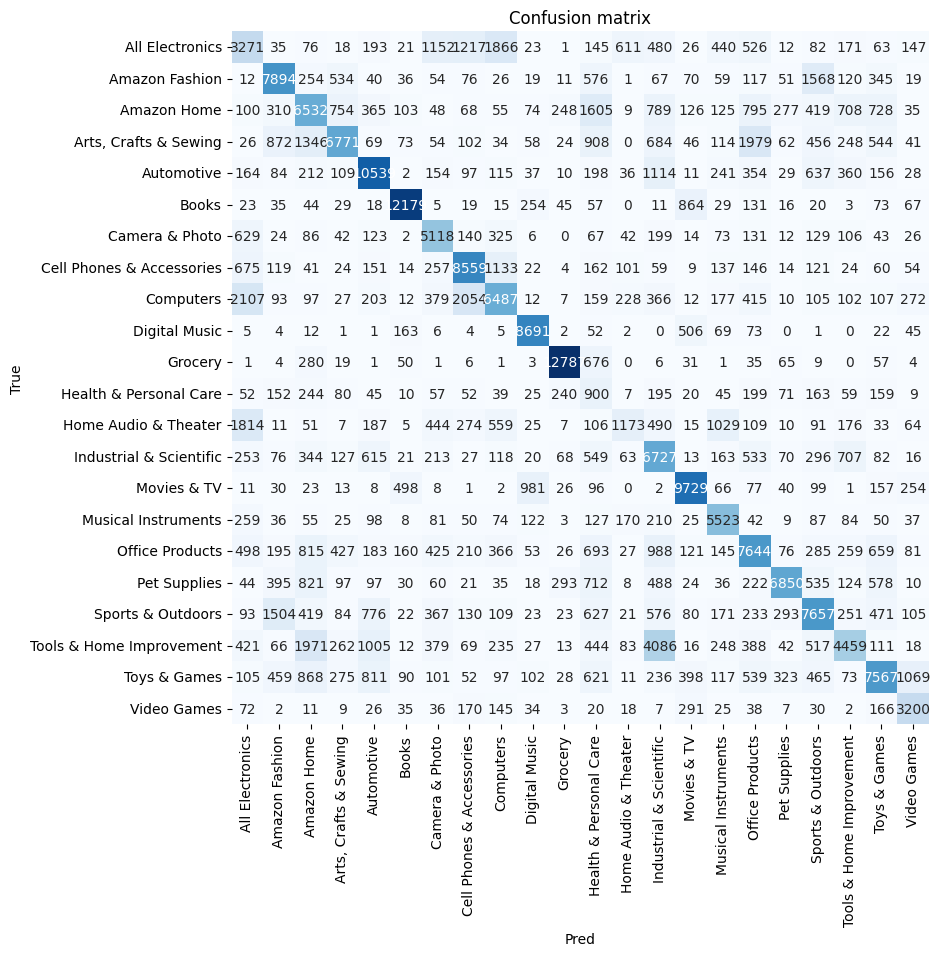

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=np.unique(y_test),
       yticklabels=np.unique(y_test), title="Confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#### Save model

In [20]:
model.save_weights('/content/bert_transfer_weights')

In [21]:
model.save('/content/bert_transfer.keras')